In [1]:
%matplotlib inline

from IPython.display import HTML, Latex, Math, display

# Data analysis
import numpy as np
import pandas as pd
import re

# Create spherical-map
import healpy as hp
import seaborn as sns

# Manage & convert astro coordinates
import astropy.units as u
import astropy.coordinates as Coord
from astropy.coordinates import SkyCoord

# Tools for Rayleigh analysis
from scipy.optimize import minimize, least_squares, curve_fit
from scipy.stats import chi2
from scipy.special import erfcinv

# Plotting
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors



In [2]:
sns.set()

def eq2gal(ra, dec):
    '''
    Transforms equatorial coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection. 
    '''
    eq = SkyCoord(ra, dec, unit=u.deg)
    gal = eq.galactic

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = -gal.l.wrap_at('180d').radian, gal.b.radian
    
    return l_gal, b_gal

def ecl2gal(lon_ecl, lat_ecl):
    '''
    Transforms ecliptic coordinates to galactic ones.
    Then prepares them for matplotlib aitoff projection.
    '''
    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame='barycentricmeanecliptic')
    gal = ecl.transform_to('galactic')

    # Minus appears because of “mapping from the inside” issue
    l_gal, b_gal = -gal.l.wrap_at('180d').radian, gal.b.radian
    
    return l_gal, b_gal

def ecl2eq(lon_ecl, lat_ecl):
    '''
    Transforms ecliptic coordinates to equatorial ones.
    Then prepares them for matplotlib aitoff projection.
    '''
    ecl = SkyCoord(lon_ecl, lat_ecl, unit=u.deg, frame='barycentricmeanecliptic')
    eq = ecl.icrs

    # Convert RA to the range [0, 360) degrees
    ra_eq = eq.ra.wrap_at(360 * u.deg).radian
    dec_eq = eq.dec.radian
    
    return ra_eq, dec_eq

def gal2eq(l_gal, b_gal):
    """
    Transform Galactic coordinates to Equatorial coordinates.
    
    Parameters:
    - l_gal: Galactic longitude in degrees
    - b_gal: Galactic latitude in degrees
    
    Returns:
    - ra_eq: Right ascension in degrees
    - dec_eq: Declination in degrees
    """
    # Create a SkyCoord object for the input Galactic coordinates
    galactic_coords = SkyCoord(l=l_gal, b=b_gal, unit=u.deg, frame='galactic')
    
    # Transform to Equatorial coordinates (ICRS frame)
    equatorial_coords = galactic_coords.icrs
    
    # Extract RA and Dec in degrees
    ra_eq = equatorial_coords.ra.deg
    dec_eq = equatorial_coords.dec.deg
    
    # Minus appears because of “mapping from the inside” issue
    ra_eq, dec_eq = -equatorial_coords.ra.wrap_at('180d').radian, -equatorial_coords.dec.radian
    
    return ra_eq, dec_eq

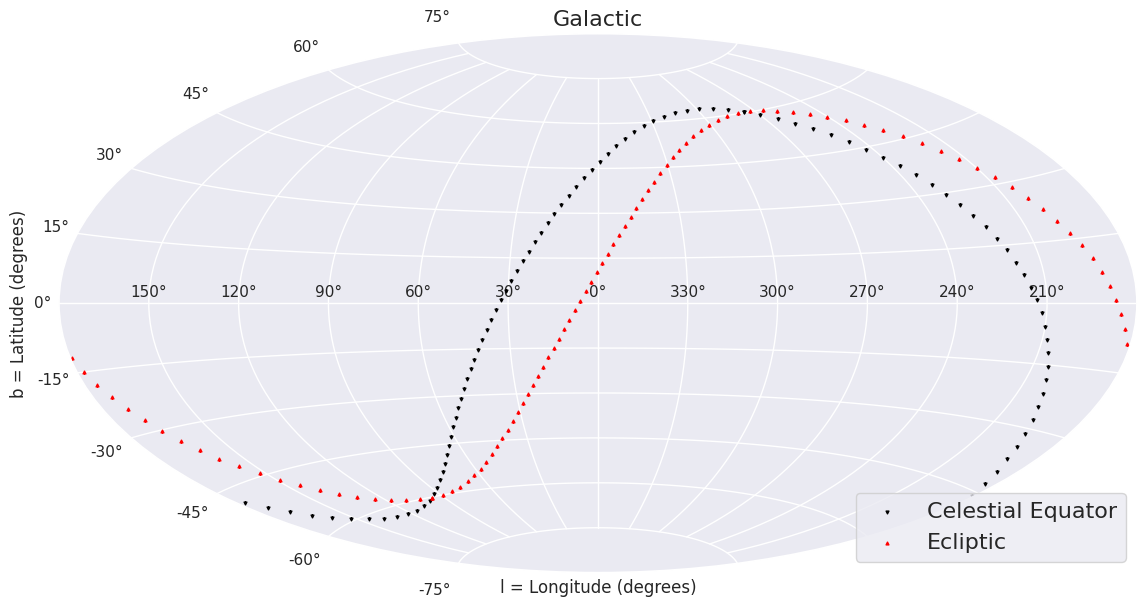

In [3]:
# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_gal, b_eq_gal = eq2gal(ra_all, dec_0)

# Ecliptic plane
lon_ecl = np.linspace(0, 360, 100)
lat_ecl = np.zeros(100)
l_ecl_gal, b_ecl_gal = ecl2gal(lon_ecl, lat_ecl)


# plot the figure
plt.figure(figsize=(14,7))
plt.subplot(111, projection='aitoff')

plt.scatter(l_eq_gal, b_eq_gal, s=4, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=4, marker='^', label='Ecliptic', color='red')

# Essential thing is to rename RA axis ticks to transform them to conventional format
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

plt.xlabel('l = Longitude (degrees)')
plt.ylabel('b = Latitude (degrees)')

plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Galactic', fontsize='16')

plt.show()

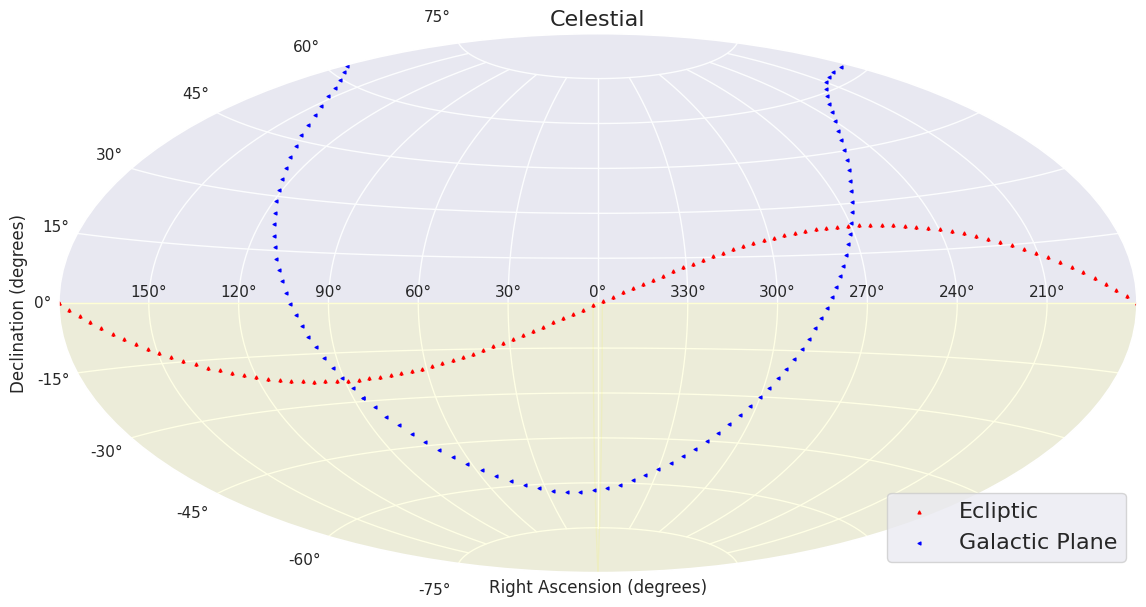

In [4]:
# Determine the hemisphere (North or South) based on celestial latitude
is_northern_hemisphere = ra_all >= 0

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = ra_all, dec_0

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100) 
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])


ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Celestial', fontsize='16')

plt.show()

The following link is the source for the blazar data: https://www.ssdc.asi.it/bzcat/#filter.

In [5]:
# AGN
# Define the column names based on the byte-by-byte description
columns = ["TMID", "RAdeg", "DEdeg", "Vel", "CAT", "Type", "S/N-1", "S/N-2", "KMag", "SSPChi2",
           "Ha-FWHMB", "Ha-FluxB", "e_Ha-FluxB", "Hb-Flux", "Ha-Flux", "O3-Flux", "N2-Flux",
           "S2a-Flux", "S2b-Flux", "e_Hb-Flux", "e_Ha-Flux", "e_O3-Flux", "e_N2-Flux",
           "e_S2a-Flux", "e_S2b-Flux", "Hb-FWHMB"]

# Load the data into a pandas DataFrame
df = pd.read_fwf("AGN.txt", skiprows=52, header=None, names=columns)

# Display the DataFrame
#print(df)
#print(df['RAdeg'])

# BLAZAR
columns_blazar = ["id", "5BZCAT Name", "Source Classification", "R.A. (J2000)", "Dec. (J2000)", "Redshift", 
                  "Redshift Flag", "1.4 GHz (0.843 MHz) Flux Density (mJy)", "143 GHz Flux Density (mJy)", 
                  "Optical Magnitude (mag)", "0.1-2.4 keV Flux (10-12 erg cm-2 s-1)", "1-100 GeV Flux (ph cm-2 s-1)"]

# Load the data into a pandas DataFrame
df_blazar = pd.read_csv("Blazar.txt", delimiter=r"\s*\|\s*", engine='python', skipinitialspace=True, skiprows=1, header=None, names=columns_blazar, delim_whitespace=False)

# Display the DataFrame
#print(df_blazar.head())
print(df_blazar["R.A. (J2000)"])

0         0.08496
1         0.27208
2         0.28592
3         0.32504
4         0.33954
          ...    
3556    359.69204
3557    359.74942
3558    359.78296
3559    359.88825
3560    359.89788
Name: R.A. (J2000), Length: 3561, dtype: float64


90


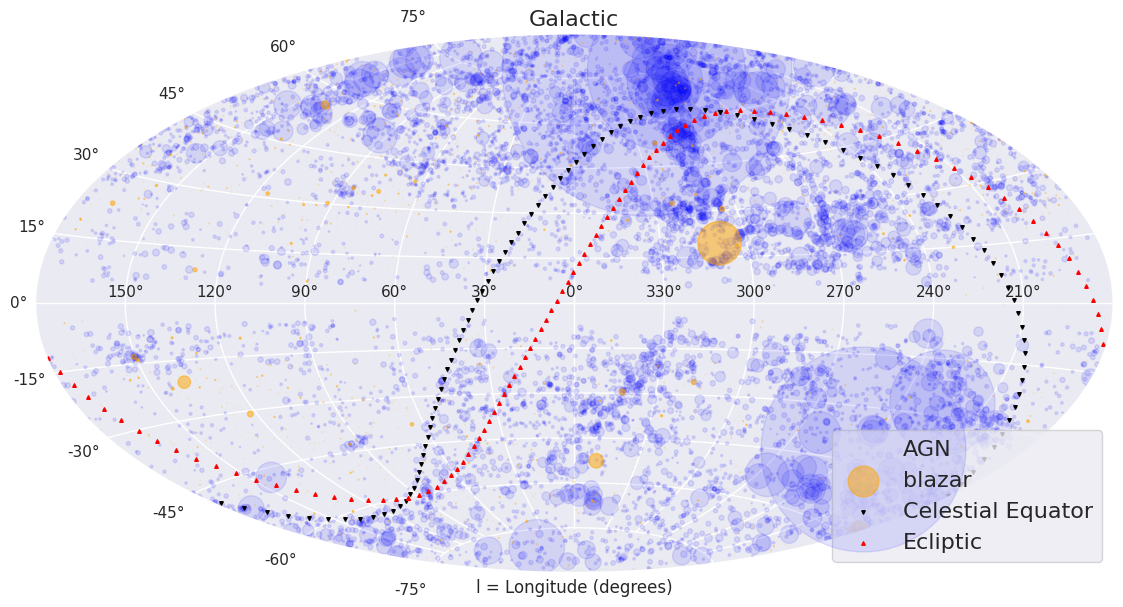

In [72]:
# Take out the coordinates from the data frame for the AGNs
ra_points = df['RAdeg']
dec_points = df['DEdeg']
vel_points = df['Vel']
dis_points = [abs(i) / 70 for i in vel_points]            # use Hubble's law to get the distance in Mpc from the redshift 
red_points = [i / (3 * 10**5) for i in vel_points]        # calculate the redshift for the sources
print(min(abs(vel_points)))
# Take out the blazar values
ra_blazar = df_blazar['R.A. (J2000)']
dec_blazar = df_blazar['Dec. (J2000)']

# Take out the redshift for the blazars and convert it to velocity and eventually distance
redshift = df_blazar['Redshift']
velocity = [i * (3 * 10**5) for i in redshift]
distance = [i / 70 for i in velocity]

# Transform the coordinates to a different frame
ra, dec = eq2gal(ra_blazar, dec_blazar)

# The Blazar distances contain NaN values, remove these and adapt the other lists containing the RA and DEC values as well
valid_indices = ~np.isnan(distance)

# Convert lists to NumPy arrays for easier manipulation
distance = np.array(distance)
ra = np.array(ra)
dec = np.array(dec)

# Filter out NaN values and corresponding values in other arrays
distance = distance[valid_indices]
ra = ra[valid_indices]
dec = dec[valid_indices]
ra_blazar = ra_blazar[valid_indices]
dec_blazar = dec_blazar[valid_indices]

# We want the scaling factor to scale with the flux which scales with 1/r^2
# We want to scale the dot size of each of the AGNs with the distance they are away from us
s_scaling_factor = 30000000.0
s = [s_scaling_factor / (max(dis_points) * i**(2)) for i in dis_points]

# We want to scale the dot size of each of the blazars with the distance they are away from us
b_scaling_factor = 30000000.0
b = [b_scaling_factor / (max(dis_points) * i**(2)) for i in distance]

# Transform the data to galactic coordinates
l_points, b_points = eq2gal(ra_points, dec_points)

#Check if the closest point is indeed the circle
#lapland, litouwen = eq2gal(1.885660E+02, 1.307551E+01)




# plot the figure
plt.figure(figsize=(14,7))
plt.subplot(111, projection='aitoff')

plt.scatter(l_points, b_points, s=s, label='AGN', color='blue', alpha=0.1)
plt.scatter(ra, dec, label='blazar', s=b, color='orange', alpha=0.5)
plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='red')
#plt.scatter(lapland, litouwen, s=1000, color='green', label='closest')


# Essential thing is to rename RA axis ticks to transform them to conventional format
plt.xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])

plt.xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Galactic', fontsize='16')

plt.show()

The following sky map shows the AGNs from the catalogue in: https://iopscience.iop.org/article/10.3847/1538-4357/aaffaf.

8491


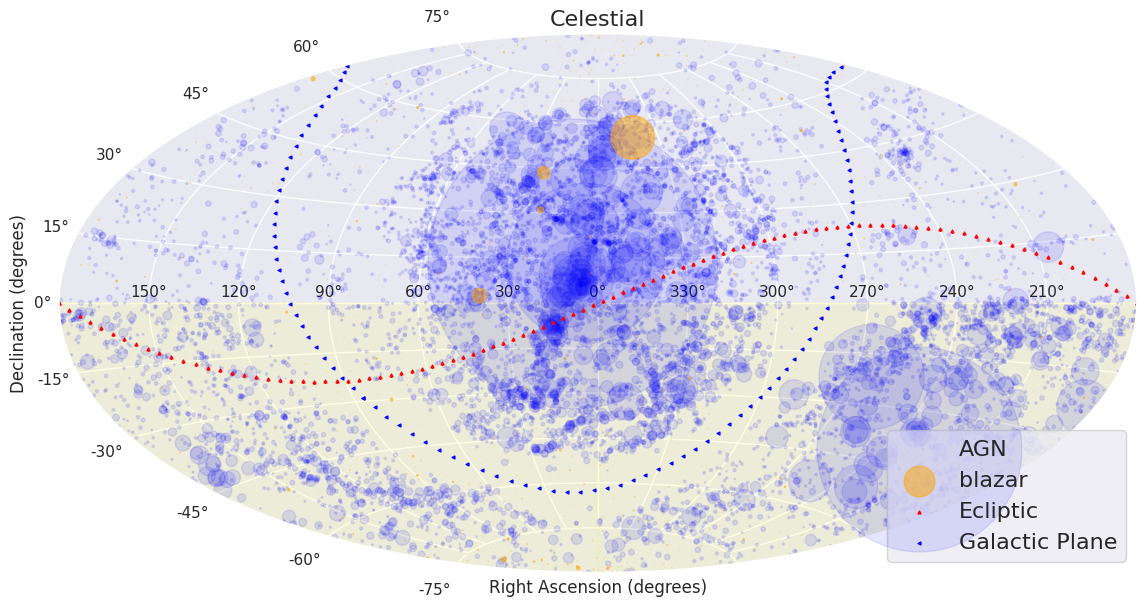

In [73]:
# Take out the coordinates from the data frame
ra_points = -(df['RAdeg'] - 180)
dec_points = np.radians(df['DEdeg']) 

# Transform RA to the range [0, 360)
ra_points = np.radians(ra_points)

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = np.radians(ra_all), np.radians(dec_0)

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100)
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

# plot the figure
plt.scatter(ra_points, dec_points, s=s, label='AGN', color='blue', alpha=0.1)
print(len(ra_points))
plt.scatter(ra_blazar, dec_blazar, label='blazar', s=b, color='orange', alpha=0.5)
ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])


ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Celestial', fontsize='16')

plt.show()

In [18]:
# GALACTIC
# Combine AGN and blazar data into a single DataFrame 
agn_data_galactic = pd.DataFrame({'RA': l_points, 'Dec': b_points, 'Type': 'AGN'})
blazar_data_galactic = pd.DataFrame({'RA': ra, 'Dec': dec, 'Type': 'Blazar'})
combined_data_galactic = pd.concat([agn_data_galactic, blazar_data_galactic], ignore_index=True)
print(len(agn_data_galactic))
print(len(blazar_data_galactic))

# Convert RA and Dec columns to numeric
combined_data_galactic['RA'] = pd.to_numeric(combined_data_galactic['RA'], errors='coerce')
combined_data_galactic['Dec'] = pd.to_numeric(combined_data_galactic['Dec'], errors='coerce')
print(len(combined_data_galactic['RA']))

# Add columns for AGN and Blazar weights
weights_galactic = pd.concat([pd.Series(s), pd.Series(b)], ignore_index=True)

# CELESTIAL
# Combine AGN and blazar data into a single DataFrame
agn_data = pd.DataFrame({'RA': df['RAdeg'], 'Dec': df['DEdeg'], 'Type': 'AGN'})
blazar_data = pd.DataFrame({'RA': ra_blazar, 'Dec': dec_blazar, 'Type': 'Blazar'})
combined_data = pd.concat([agn_data, blazar_data], ignore_index=True)
print(len(agn_data))
print(len(blazar_data))

# Convert RA and Dec columns to numeric
combined_data['RA'] = pd.to_numeric(combined_data['RA'], errors='coerce')
combined_data['Dec'] = pd.to_numeric(combined_data['Dec'], errors='coerce')
print(len(combined_data['RA']))

# Add columns for AGN and Blazar weights
weights = pd.concat([pd.Series(s), pd.Series(b)], ignore_index=True)

8491
2842
11333
8491
2842
11333


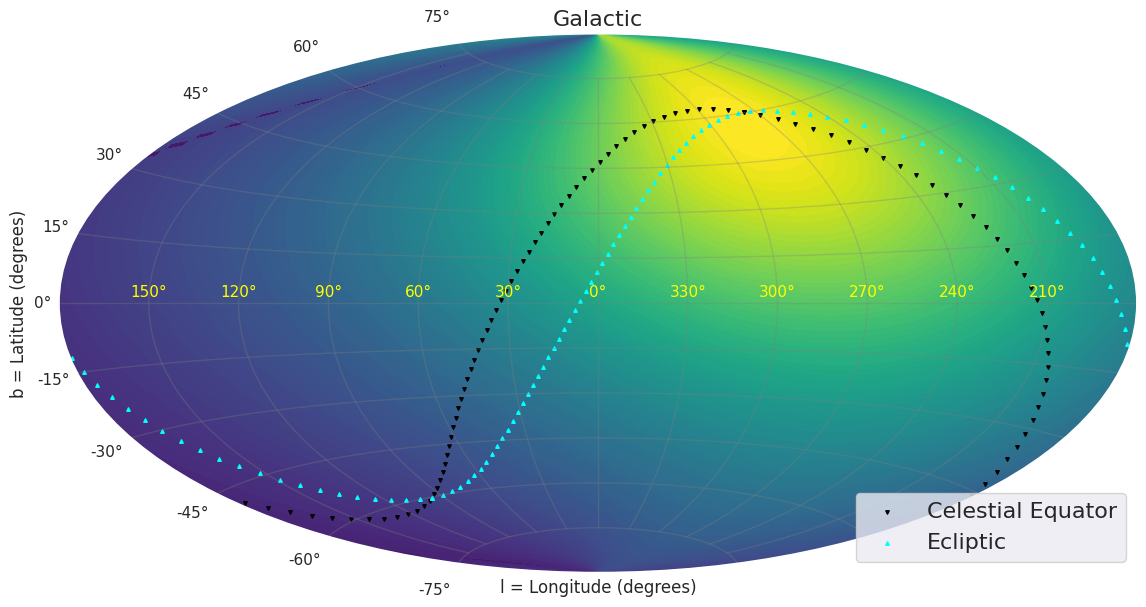

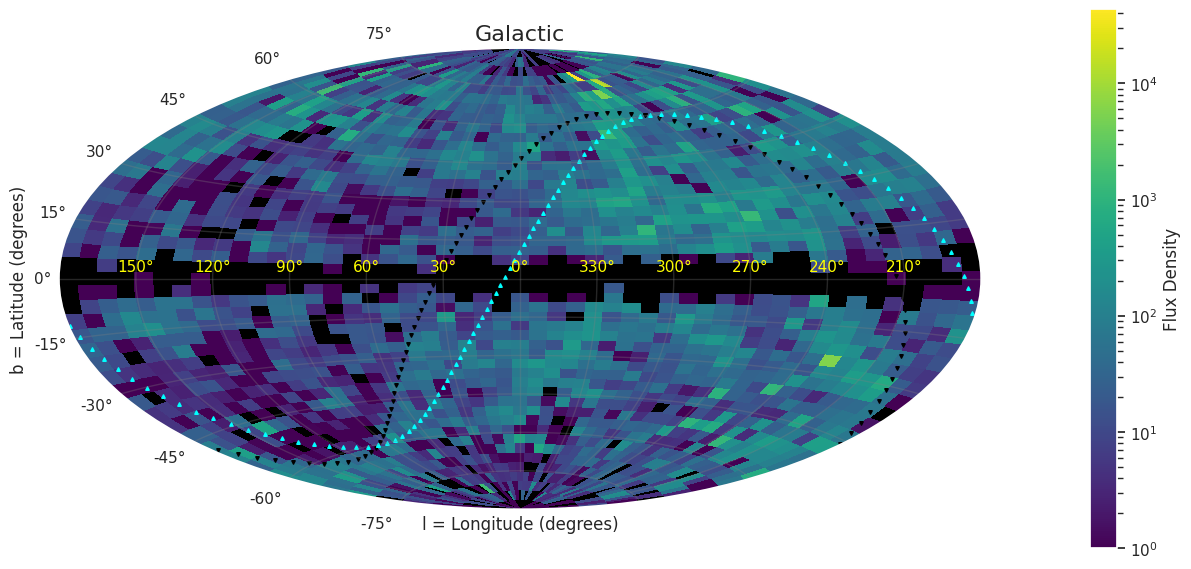

In [78]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = combined_data_galactic['RA']
dec_set = combined_data_galactic['Dec']

# Specify the number of bins in each direction
ra_bins = np.linspace(-np.pi, np.pi, num=50)
dec_bins = np.linspace(-np.pi/2, np.pi/2, num=50)

# Use numpy.histogram2d to create a 2D histogram with weights
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights_galactic)

# Create a meshgrid from the edges
RA, DEC = np.meshgrid(ra_edges, dec_edges)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Overlay the KDE plot
kde = sns.kdeplot(x=ra_set, y=dec_set, cmap='viridis', fill=True, thresh=0, levels=100, weights=weights_galactic, ax=ax, zorder=0, bw_method=1)

plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='cyan')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Galactic', fontsize='16')
plt.legend(fontsize=16, loc='lower right')

plt.show()



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Plot the 2D histogram using pcolormesh first
pc = ax.pcolormesh(RA, DEC, hist.T, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=hist.max()), zorder=1)
ax.set_facecolor('black')

plt.scatter(l_eq_gal, b_eq_gal, s=6, marker='v', label='Celestial Equator', color='black')
plt.scatter(l_ecl_gal, b_ecl_gal, s=6, marker='^', label='Ecliptic', color='cyan')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Flux Density')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Galactic', fontsize='16')

plt.show()

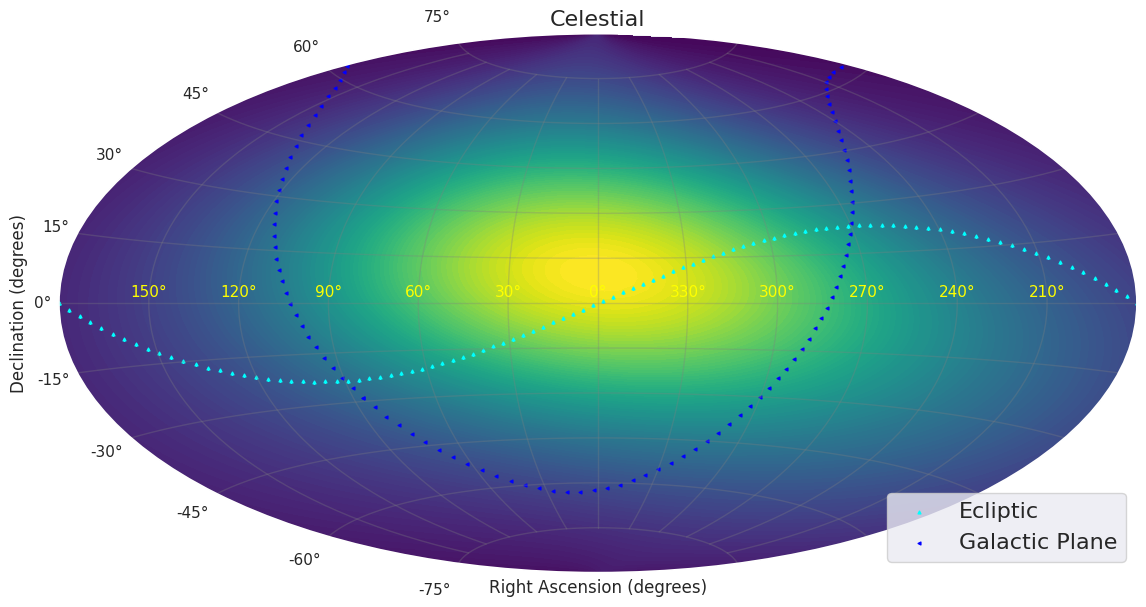

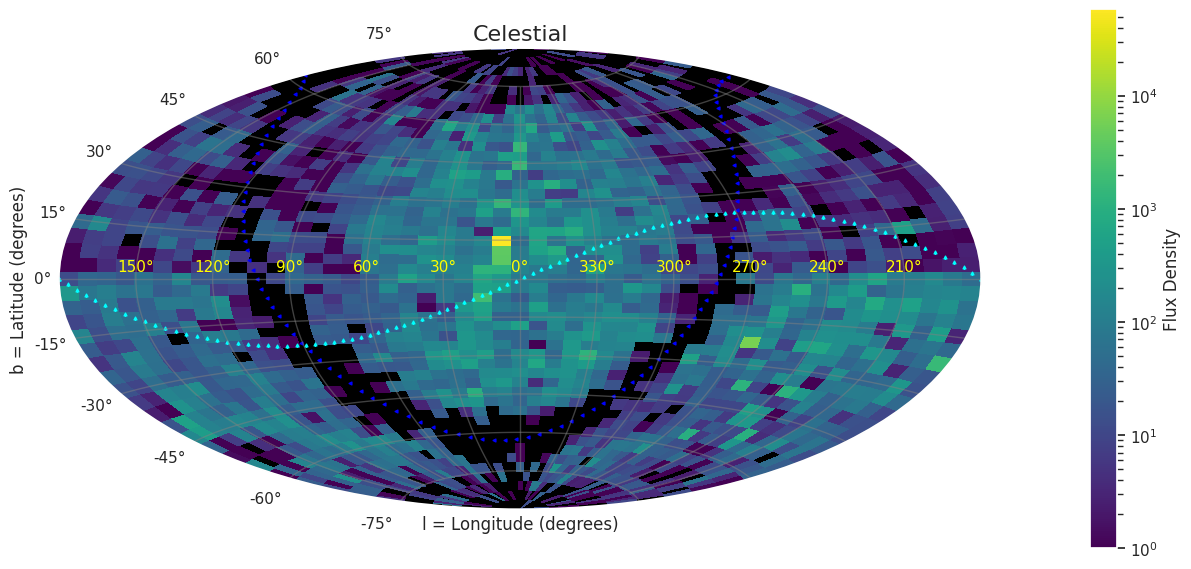

In [75]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = -np.radians(combined_data['RA'] - 180)
dec_set = np.radians(combined_data['Dec'])

# Specify the number of bins in each direction
ra_bins = np.linspace(-np.pi, np.pi, num=50)
dec_bins = np.linspace(-1/2*np.pi, 1/2*np.pi, num=50)

# Use numpy.histogram2d to create a 2D histogram with weights
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights)

# Create a meshgrid from the edges
RA, DEC = np.meshgrid(ra_edges, dec_edges)

# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Overlay the KDE plot
sns.kdeplot(x=ra_set, y=dec_set, cmap='viridis', fill=True, thresh=0, levels=100, weights=weights, ax=ax, bw_method=1)
ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='cyan')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='cyan')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.3, color='gray')
plt.title('Celestial', fontsize='16')
plt.legend(fontsize=16, loc='lower right')

plt.show()



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Plot the 2D histogram using pcolormesh first
pc = ax.pcolormesh(RA, DEC, hist.T, cmap='viridis', norm=colors.LogNorm(vmin=1, vmax=hist.max()), zorder=1)
ax.set_facecolor('black')

ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='cyan')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='cyan')
ax.scatter(l_gal_cel, b_gal_cel, s=4, marker='<', label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180]))
ax.set_xticklabels(['', '150°', '120°', '90°', '60°', '30°', '0°', '330°', '300°', '270°', '240°', '210°', ''], color='yellow')

ax.set_xlabel('l = Longitude (degrees)')
ax.set_ylabel('b = Latitude (degrees)')

# Add a colorbar
cbar = plt.colorbar(pc, ax=ax, orientation='vertical', fraction=0.05, pad=0.1)
cbar.set_label('Flux Density')

# Set the zorder for the x-axis and y-axis
ax.xaxis.set_zorder(2)
ax.yaxis.set_zorder(2)

plt.grid(True, alpha=0.5, color='gray')
plt.title('Celestial', fontsize='16')

plt.show()

In [64]:
# Assuming combined_data['RA'] and combined_data['Dec'] are your right ascension and declination arrays
ra_set = -np.radians(combined_data['RA'] - 180)
dec_set = np.radians(combined_data['Dec'])

# Specify the number of bins in each direction such that we have two hemispheres
ra_bins = np.linspace(-np.pi, np.pi, num=2)
dec_bins = np.linspace(-1/2*np.pi, 1/2*np.pi, num=3)

# Use numpy.histogram2d to create a 2D histogram with weights and calculate the histogram value for each of the hemispheres
hist, ra_edges, dec_edges = np.histogram2d(ra_set, dec_set, bins=[ra_bins, dec_bins], weights=weights)

print(f"The histogram value for the northern hemisphere, which represents the flux is {round(hist[0][1])}. That of the sourthern hemisphere is {round(hist[0][0])}. This means that the flux in the northern hemisphere would be more substantial by a factor of approximately {round((hist[0][1])/(hist[0][0]), 2)}.")


The histogram value for the northern hemisphere, which represents the flux is 121464. That of the sourthern hemisphere is 85119. This means that the flux in the northern hemisphere would be more substantial by a factor of approximately 1.43.


Import the auger data from the following website: https://opendata.auger.org/analysis.php#nb_json

In [11]:
# Data loading, encapsulated to make it less installation and OS dependant
import os.path
from zipfile import ZipFile
def AugerLoad(fdir,file):
    """
    Loads a file from the auger open data release. Can be either in the local directory,
    in the parent directory or in the augeropendata directory.
    File is identified by it directory *fdir* and filename *file* and can be found in the directory
    or in a zip file.
    """
    for loc in [".","..","augeropendata"]:
        fname=os.path.join(loc,fdir,file)
        if os.path.isfile(fname):
            return open(fname)
        zname=os.path.join(loc,fdir+".zip")
        if os.path.isfile(zname):
            with ZipFile(zname) as myzip:
                return myzip.open(os.path.join(fdir,file))

Look for high energy events of E > 2.5 EeV.

In [12]:
# Safeguard: select only events above Eth = 2.5 EeV, where full efficiency is reached for zenith angles < 60°
Eth = 10 # EeV = 10^19 eV
e_cut = (raw_data.sd_energy>Eth)
data = raw_data[e_cut]
totalExposure = data.sd_exposure.iloc[-1]

# Example: print the energy and the galactic coordinates of a randomly selected event
event = np.random.randint(0, data.shape[0])
example = data.iloc[event]

display(Latex(f'''Event #{event}:
\\begin{{align}}
E &= {example.sd_energy}\\,\\mathrm{{EeV}}\\\\
l &= {example.sd_l} ^\circ\\\\
b &= {example.sd_b} ^\circ\\\\
\\end{{align}}
'''))



# In order to plot the dots with size representing energy we do the following
energy = data.sd_energy
print()
size_scaling_factor = 100.0
sizes = size_scaling_factor * energy / max(energy)

NameError: name 'raw_data' is not defined

In [ ]:
print(data.sd_energy)

# Take out the coordinates from the data frame
ra_points = -(df['RAdeg'] - 180)
dec_points = np.radians(df['DEdeg'])  # Assuming you want to negate declinations

# Transform RA to the range [0, 360)
ra_points = np.radians(ra_points)

# Equatorial plane
ra_all = np.linspace(-180, 180, 100)
dec_0 = np.zeros(100)
l_eq_cel, b_eq_cel = np.radians(ra_all), np.radians(dec_0)

# Ecliptic plane
lon_ecl = np.linspace(-180, 180, 100)
lat_ecl = np.zeros(100)
l_ecl_cel, b_ecl_cel = ecl2eq(lon_ecl, lat_ecl)

# Galactic plane
l_gal_plane = np.linspace(-180, 180, 100)
b_gal_plane = np.zeros(100)
l_gal_cel, b_gal_cel = gal2eq(l_gal_plane, b_gal_plane)

# Determine the hemisphere (North or South) based on celestial latitude
is_northern_hemisphere = ra_all >= 0



# Plot the figure
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, projection='aitoff')

# Fill the area above the celestial equator with a different color
ax.fill_between(np.radians(l_gal_cel), np.pi, where=is_northern_hemisphere, alpha=0.01)

# Fill the area below the celestial equator with a different color
ax.fill_between(np.radians(l_eq_gal), -np.pi, where=~is_northern_hemisphere, color='yellow', alpha=0.1)

# plot the figure
ax.scatter(data.sd_ra, np.radians(data.sd_dec), s=sizes, color='darkviolet', label='Auger Sources')
ax.scatter(ra_points, dec_points, s=s, label='AGN', color='blue', alpha=0.1)
ax.scatter(l_ecl_cel, b_ecl_cel, s=4, marker='^', label='Ecliptic', color='red')
ax.scatter(-1*l_ecl_cel, -1*b_ecl_cel, s=4, marker='^', color='red')
ax.scatter(l_gal_cel, b_gal_cel, s=4, label='Galactic Plane', color='blue')

# Essential thing is to rename RA axis ticks to transform them to conventional format
# Essential thing is to rename RA axis ticks to transform them to conventional format
ax.set_xticks(ticks=np.radians([-150, -120, -90, -60, -30, 0, \
                             30, 60, 90, 120, 150]),
           labels=['150°', '120°', '90°', '60°', '30°', '0°', \
                   '330°', '300°', '270°', '240°', '210°'])


ax.set_xlabel('Right Ascension (degrees)')
ax.set_ylabel('Declination (degrees)')
plt.grid(True)
plt.legend(fontsize=16, loc='lower right')
plt.title('Celestial', fontsize='16')

plt.show()